In [38]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import matplotlib
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
sampling_methods = ["importance_sampling","beam_search_is_hybrid"]
lens = [(17,20)]
temps = [1]
data_paths = "../data/{}/shakespeare/is_v_hybrid/val-dl_{}_{}h_{}s_{:03}t.pkl"

In [23]:
datas = []
for h,s in lens:
    for t in temps:
        data = []
        for sampling_method in sampling_methods:
            curr_data_path = data_paths.format(sampling_method, sampling_method,h,s,t)
            curr_data = read_pkl(curr_data_path)
            data.append(curr_data)
        datas.append(data)

In [30]:
imp_samp, hybrid = datas[-1]
imp_data = torch.gather(imp_samp['sample_est_var'],1,imp_samp['excluded_terms'].reshape(-1,1)).flatten().numpy()
hybrid_data = torch.gather(hybrid['hybrid_var'],1,hybrid['excluded_terms'].reshape(-1,1)).flatten().numpy()
print(imp_data.shape,hybrid_data.shape)

(2287,) (2287,)


In [31]:
# print(imp_data.mean())
diffs = (imp_data - hybrid_data)/(imp_data + 1e-10)

In [32]:
imp_data.max()/hybrid_data.max()

54.941673

In [33]:
diffs[diffs<0] = 0

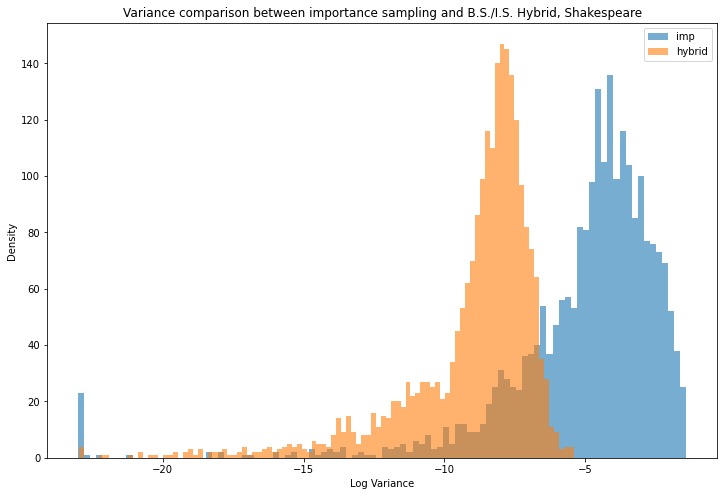

In [34]:
plt.figure(figsize=(12,8))
plt.hist(np.log(imp_data + 1e-10), label = "imp", bins = 100,alpha=0.6)
plt.hist(np.log(hybrid_data + 1e-10), label = "hybrid",bins=100,alpha=0.6)
plt.legend()
plt.xlabel("Log Variance")
plt.ylabel("Density")
plt.title("Variance comparison between importance sampling and B.S./I.S. Hybrid, Shakespeare")
plt.show()

# plt.hist(diffs.numpy(),bins=100)

0.95586836


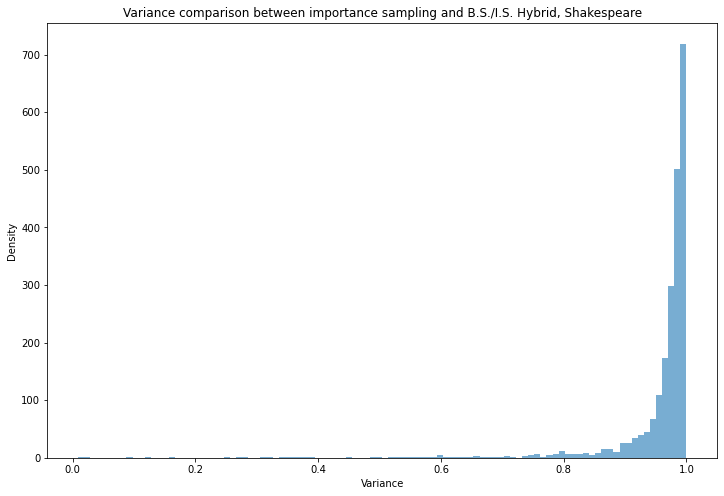

In [35]:
diffs = (imp_data - hybrid_data + 1e-10)/(imp_data + 1e-10)
diffs = diffs[diffs>=0]
print(diffs.mean())
plt.figure(figsize=(12,8))
plt.hist(diffs, label = "hybrid",bins=100,alpha=0.6)
plt.xlabel("Variance")
plt.ylabel("Density")
plt.title("Variance comparison between importance sampling and B.S./I.S. Hybrid, Shakespeare")
plt.show()


## Model iterations v. MAE

In [9]:
print(os.listdir("../"))

['.git', 'README.md', 'requirements.txt', '.ipynb_checkpoints', 'data', 'setup.sh', 'models', '__pycache__', 'archive', '.gitignore', 'seq_queries', 'test', 'config', 'notebooks', 'logs', 'imgs', 'scripts', 'scratch.py', '.vim', 'LICENSE']


In [13]:
methods = ['ground_truth','importance_sampling','beam_search_is_hybrid']
dataset = 'shakespeare'
experiment='val_dl'
lengths = [(18,20)]

data_dict = {}
for length in lengths:
    for method in methods:
        h,s = length
        path_template = f"../data/{method}/{dataset}/{experiment}/{experiment.replace('_','-')}_{dataset}_{method.replace('_','-')}_{h}h_{s}s*.pkl"
        print(path_template)
        pot_paths = glob.glob(path_template)
        assert len(pot_paths) == 1,\
            f"Paths: {pot_paths}"
        data_dict[method] = read_pkl(pot_paths[0])
    

../data/ground_truth/shakespeare/val_dl/val-dl_shakespeare_ground-truth_18h_20s*.pkl
../data/importance_sampling/shakespeare/val_dl/val-dl_shakespeare_importance-sampling_18h_20s*.pkl
../data/beam_search_is_hybrid/shakespeare/val_dl/val-dl_shakespeare_beam-search-is-hybrid_18h_20s*.pkl


In [24]:
print(data_dict['ground_truth'].keys())
print(data_dict['beam_search_is_hybrid'].keys())

dict_keys(['num_beams', 'dist_lower_bound', 'true_coverage', 'restricted_coverage', 'metadata', 'excluded_terms'])
dict_keys(['bs_lower_bound', 'is_estimate', 'hybrid_bs_is_estimate', 'model_runs', 'hybrid_var', 'hybrid_mean', 'num_beams', 'true_coverage', 'restricted_coverage', 'metadata', 'excluded_terms'])


In [85]:
def plot_against_samples(data_dict, sub_estimates = [10,100,1000,10000]):
    sub_estimates = data_dict['importance_sampling']['metadata']['sub_estimates']
    importance_estimates= data_dict['importance_sampling']['sample_estimates']
    excluded_terms = data_dict['beam_search_is_hybrid']['excluded_terms']
    gt= data_dict['ground_truth']['dist_lower_bound'].reshape(-1,68)[:,excluded_terms[0]].flatten()
    hybrid_estimates= data_dict['beam_search_is_hybrid']['hybrid_bs_is_estimate']
    hybrid_estimates = torch.stack([
        torch.gather(hybrid_estimates[:,:s].mean(dim=1),1,
                     excluded_terms.unsqueeze(-1))
                     for s in sub_estimates],dim=1).squeeze()
    print(gt[10], hybrid_estimates[10], importance_estimates[10])
    importance_diffs = torch.abs(importance_estimates - gt.unsqueeze(-1))
    hybrid_diffs = torch.abs(hybrid_estimates - gt.unsqueeze(-1))
    
    importance_df = pd.DataFrame(importance_diffs, columns=sub_estimates)
    importance_df = pd.melt(importance_df, value_vars=sub_estimates)
    importance_df['method'] = 'importance_sampling'
    hybrid_df = pd.DataFrame(hybrid_diffs, columns=sub_estimates)
    hybrid_df = pd.melt(hybrid_df, value_vars=sub_estimates)
    hybrid_df['method'] = 'hybrid_search_sample'
    # print(hybrid_df.shape, importance_df.shape)
    df = pd.concat([importance_df,hybrid_df],ignore_index = True,axis=0)
    print(df.head())
    
    plt.figure(figsize=(12,8))
    matplotlib.rcParams.update({'font.size': 22})
    fig,ax = plt.subplots(figsize=(15,8))
    sns.boxplot(x ='variable',y='value',hue='method',data=df)
    plt.xlabel("Number of samples")
    plt.ylabel(r"MAE of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
    plt.title("Shakespeare, Seq. Len=2 Hybrid v. Importance Sampling")
    plt.xticks(rotation=45)
    # plt.ylim(-0.01,0.3)
    plt.tight_layout()


tensor(0.0301) tensor([0.0887, 0.1420, 0.1496, 0.1497, 0.1497]) tensor([0.1815, 0.1745, 0.1493, 0.1471, 0.1471])
   variable     value               method
0        10  0.142783  importance_sampling
1        10  0.346656  importance_sampling
2        10  0.698117  importance_sampling
3        10  0.196759  importance_sampling
4        10  0.193125  importance_sampling


<Figure size 864x576 with 0 Axes>

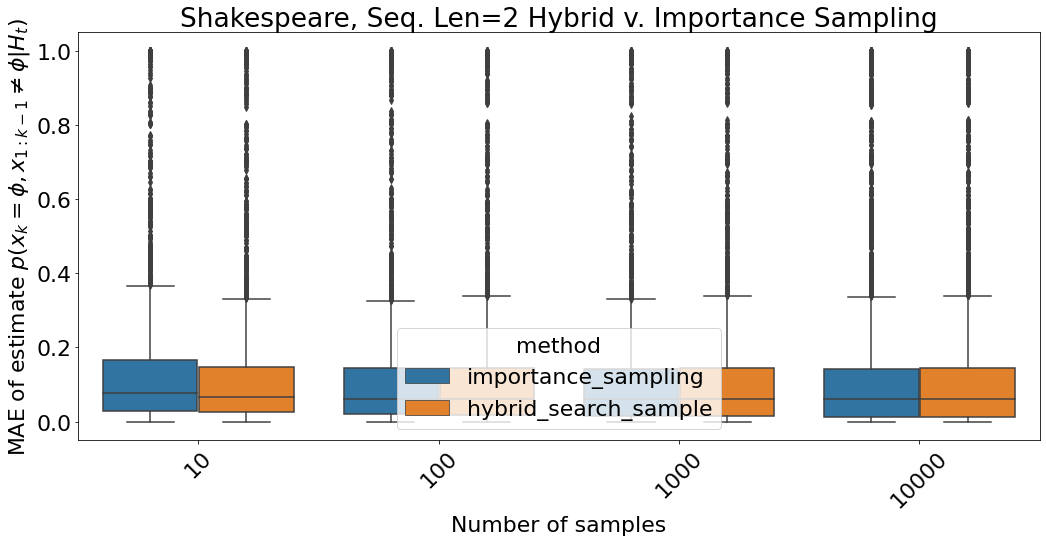

In [86]:
plot_against_samples(data_dict)